# High Value Customers Identification (Insiders) #
**By: Marx Cerqueira**

**Background of Problem Statement:**

All-in-One-Place company is a online retail store based in UK, and has captured the sales data for different products for the period of one year (Nov 2016 to Dec 2017).

Within just one year of operation, the marketing team realized that some customers buy more expensive products with high frequency and contribute to a significant portion of the company's revenue.

Due to this, the marketing team will launch a loyalty program for the best customers in the company's database, called High Value Customers. However, the team does not have advanced knowledge of data analysis to select program participants.

For this reason, the marketing team asked the data science team to select eligible customers for this loyalty program using advanced data manipulation and modeling techniques.

**Project Objective:**
Find significant customers for the business who make high purchases of their favourite products. The organization wants to roll out a loyalty program to the high-value customers after identification of segments. Use the clustering methodology to segment customers into groups.

## Project Solution Planning

### Input

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
2. Conjunto de dados
    - Vendas de um ecommerce, durante um período de um ano (nov 2015 to Dec 2017)

### Output


1. Indicação das pessoas que farão parte do programa de fidelização (insiders)
    - Lista: client_id > Is insider
             11321     > yes/1
             14332     > no/1
             
2. Relatório com as respostas das perguntas de negócio

    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: ** criação de features **
        - Alto Ticket Médio (média do valor gasto por cliente, quanto o cliente gasta na média com a empresa;
        - Alto LTV (Life Time Value);
        - Baixa Recência (tempo da última compra), queremos uma recência menor ou Alta Frequência (tempo entre as compras);
        - Alto basket size;
        - Baixa probabilidade de Churn;
        - Alta previsão de LTV;
        - Alta propensão de compra;
        
    - Custos:
        - Baixa taxa de devolução; A empresa tem um custo por devolução, normalmente essa taxa é definida no modelo de negócio da empresa (business plan);        
        
    - Experiência de compra:
        - Média alta das avaliações
    
2. **Quantos clientes farão parte do grupo?**
    - Número total de clientes
    - % do grupo Insiders
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever as características do cliente:
        - Idade
        - Localização 
        - em resumo é o look a like
    - Escrever características do consumo.
        - Atributos da clusterização;

4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Faturamento total do ano
    - Faturamento do grupo Insiders (verificar quantos % da receita total vem desse grupo)
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - LTV do grupo Insiders
    - Análise de Cohort
6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Definir a periodicidade do modelo (1 mes, 3 meses...)
    - O "desempenho" do cliente está próximo da média do cluster Insiders
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - Definir a periodicidade do modelo (1 mes, 3 meses...)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses.
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Desconto
    - Preferencia de compra
    - Frete
    - Visita a empresa, etc.

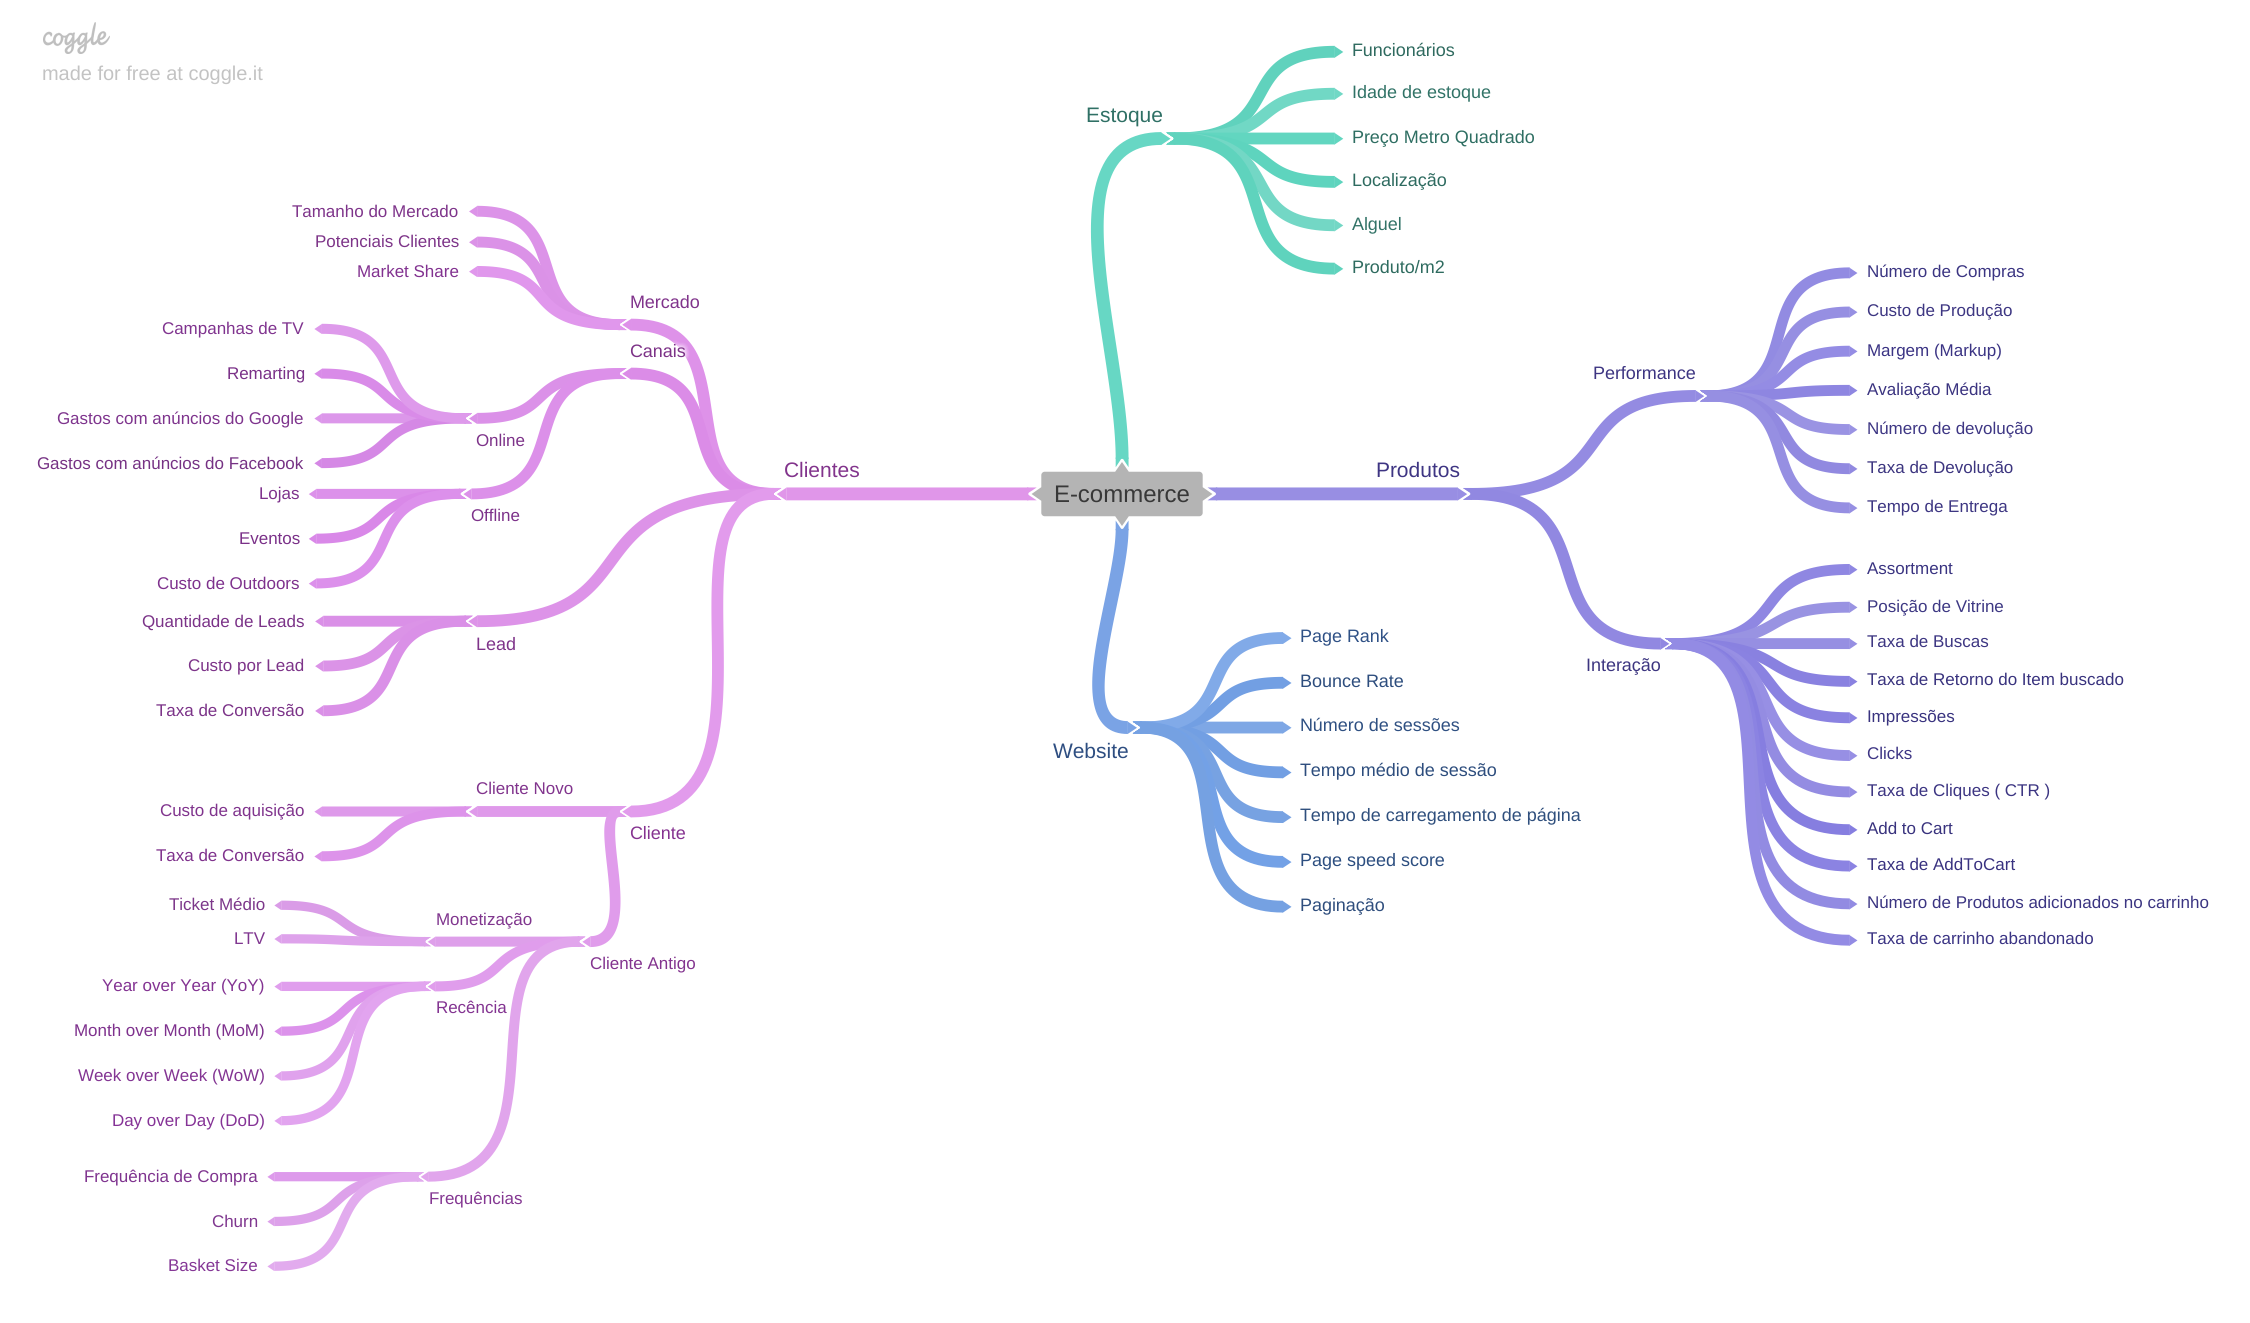

In [1]:
from IPython.display import Image
Image(filename='/home/marxcerqueira/repos/Kaggle-HighValue-Custormers-Identification/reports/figures/mapa_metricas_e_commerce.png')

## E-commerce Metrics

- **Growth Metrics**:
    1. Porcentagem do Marketshare
    2. Número de Clientes Novos
- **Revenue Metrics**:
    1. Número de Vendas
    2. Ticket Médio
    3. LTV ( Long Time Value )
    4. Recência Média
    5. Basket Size Médio
    6. Markup médio
- **Cost Metrics**:
    1. CAC ( Custo de aquisição de Clientes )
    2. Desconto médio
    3. Custo de Produção
    4. Taxa de devolução
    5. Custos Fixos ( Folha de pagamento, escritório, softwares )
    6. Impostos

## Benchmark de Soluções

Desk Research
1. Fazer pesquisas sobre o que as pessoas já fizeram, quais problemas de clusterização resolveram e como resolveram.
2. Leitura dos artigos
3. Resultado: 3 ou 4 soluções que você entendeu, e verificar o que da pra aproveitar para o nosso contexto.

# IMPORTS

In [27]:
import os
import inflection
import sqlite3

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.ticker   as mticker
import matplotlib.colors   as mcolors
import matplotlib.pyplot   as plt


from IPython.display import HTML
from IPython.display import Image
from operator        import attrgetter

from sqlalchemy import create_engine

from platform                import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.2


## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [3]:
# get AWS environmnet access keys
AWS_ACCESS_KEY_ID     = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

In [4]:
# load data
path_s3 = 's3://mc-insiders-dataset/'

df_ecomm_raw = pd.read_csv(path_s3 + 'Ecommerce.csv',
                           encoding='iso-8859-1',
                           low_memory=False)

#drop extra column
df_ecomm_raw = df_ecomm_raw.drop(columns = ['Unnamed: 8'], axis = 1)

In [7]:
df_ecomm_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# DATA DISCRIPTION

In [5]:
# Copy dataset
df0 = df_ecomm_raw.copy()

In [6]:
colunas_df0 = df0.columns

In [7]:
colunas_df0

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
snakecase = lambda x: inflection.underscore(x)
col_news = list(map(snakecase, colunas_df0))

In [9]:
col_news

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_id',
 'country']

In [10]:
df0.columns = col_news

## Rename Columns

In [9]:
cols_old = ['InvoiceNo','StockCode','Description','Quantity', 'InvoiceDate','UnitPrice','CustomerID','Country']

snakecase = lambda x: inflection.underscore(x)
col_news = list(map(snakecase, cols_old))

# Rename columns
df0.columns = col_news

Attribute Description:

    - InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
    - StockCode: Product (item) code
    - Description: Product (item) name
    - Quantity The quantities of each product (item) per transaction
    - InvoiceDate: The day when each transaction was generated
    - UnitPrice: Unit price (Product price per unit)
    - CustomerID: Customer number (Unique ID assigned to each customer)
    - Country: Country name (The name of the country where each customer resides)

## Data Dimension

In [10]:
print('Number of rows: {}.'.format(df0.shape[0]))
print('Number of cols: {}.'.format(df0.shape[1]))

Number of rows: 541909.
Number of cols: 8.


## Data Types

In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Check NA Values

In [12]:
missing_count = df0.isnull().sum() # the count of missing values
value_count = df0.isnull().count() # the total values count

missing_percentage = round(missing_count/value_count*100,2) # the percentage of missing values
missing_df = pd.DataFrame({'missing value count': missing_count, 'percentage': missing_percentage})
missing_df

,missing value count,percentage
invoice_no,0,0.00
stock_code,0,0.00
description,1454,0.27
quantity,0,0.00
invoice_date,0,0.00
unit_price,0,0.00
customer_id,135080,24.93
country,0,0.00


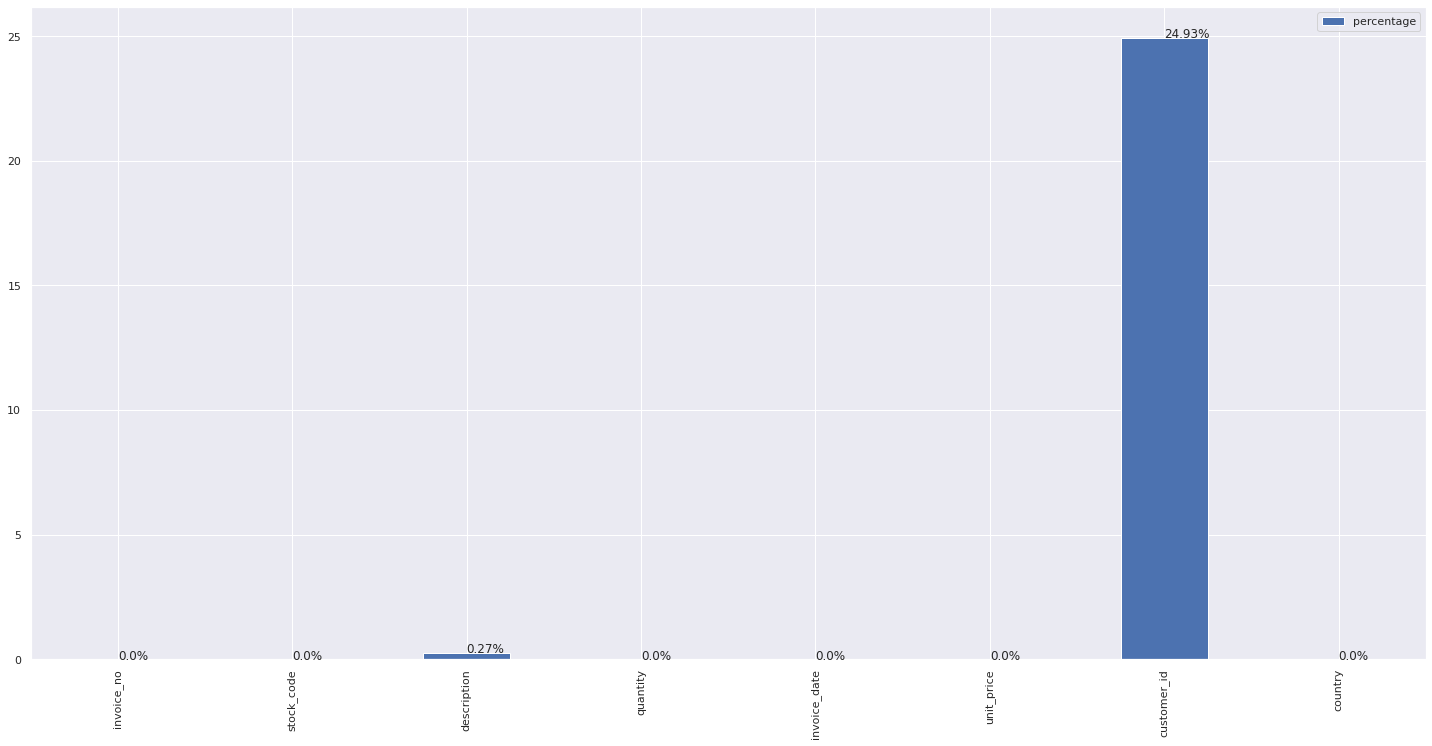

In [13]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

## Fillout NA

In [12]:
# separate NA's in two different dataframe, one with NAs and other without it
df_missing = df0.loc[df0['customer_id'].isna(), :]
df_not_missing = df0.loc[~df0['customer_id'].isna(), :]

In [13]:
df_not_missing.shape

(406829, 8)

In [14]:
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [15]:
## Fillout NA stratety, creating customers_id to keep their behavior (25% of the database)
df_not_missing['customer_id'].max()

18287.0

In [16]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates().copy() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1) # Fillout NA stratety: creating customers_id to keep their behavior (25% of the database)

# merge original with reference dataframe
df0 = pd.merge( df0, df_backup, on='invoice_no', how='left' )

# coalesce 
df0['customer_id'] = df0['customer_id_x'].combine_first( df0['customer_id_y'] )

# drop extra columns
df0 = df0.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [17]:
df0.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change Types

In [18]:
# Transforme datatype of variable invoice_date to datetime
df0['invoice_date'] = pd.to_datetime(df0['invoice_date'])

In [19]:
df0['customer_id'] = df0['customer_id'].astype('int64')

In [20]:
df0.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [21]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
customer_id,541909.0,16688.840453,2911.411352,12346.00,14367.00,16249.00,18283.00,22709.0


In [22]:
df0.describe(include = object).T

,count,unique,top,freq
invoice_no,541909,25900,573585,1114
stock_code,541909,4070,85123A,2313
description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
country,541909,38,United Kingdom,495478


In [29]:
num_attributes = df0.select_dtypes(include = 'number')
cat_attributes = df0.select_dtypes(exclude = ['number', np.datetime64])

### Numerical Attributes

In [30]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - desvio padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

m1 = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana','std', 'skew','kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


**Num Attributes Investigating**:

    1. Quantity negativa (could it be returned items?)
    2. Preço unitário igual a zero e negativo(could it be discount?)

### Categorical Attributes

In [31]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice_No

In [28]:
# problem: We got letters and numbers in invoice_no
#df0['invoice_no'].astype( int )

# identification: 
df_letter_invoices = df0.loc[df0['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices with letter on it: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of invoices with negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices with letter on it: 9291
Total number of invoices with negative quantity: 9288


#### Stock_Code

In [29]:
# check stock codes only characters
df0.loc[df0['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [30]:
df0.head()

# Action: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [31]:
df0['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [32]:
# purchases per country (percentage)
df0['country'].value_counts( normalize=True)*100

United Kingdom          91.431956
Germany                  1.752139
France                   1.579047
EIRE                     1.512431
Spain                    0.467422
Netherlands              0.437527
Belgium                  0.381798
Switzerland              0.369435
Portugal                 0.280305
Australia                0.232327
Norway                   0.200403
Italy                    0.148180
Channel Islands          0.139876
Finland                  0.128250
Cyprus                   0.114779
Sweden                   0.085254
Unspecified              0.082302
Austria                  0.073998
Denmark                  0.071783
Japan                    0.066063
Poland                   0.062926
Israel                   0.054806
USA                      0.053699
Hong Kong                0.053145
Singapore                0.042258
Iceland                  0.033585
Canada                   0.027864
Greece                   0.026942
Malta                    0.023436
United Arab Em

In [33]:
# customers per country
df0[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# VARIABLE FILTERING

In [32]:
df1 = df0.copy()

In [33]:
 # === Numerical attributes ====
df1 = df1.loc[df1['unit_price'] >= 0.04, :]

# === Categorical attributes ====
#stock code
df1 = df1[~df1['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                    'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df1 = df1.drop( columns='description', axis=1 )

# country 
df1 = df1[~df1['country'].isin( ['European Community', 'Unspecified' ] ) ] #assuming this risk so we can use lat long parameters

# bad customers
df1 = df1[~df1['customer_id'].isin([16446, 12346, 15098])]

# quantity 
df1_returns = df1.loc[df1['quantity'] < 0, :].copy() # considering negative quantity is equal returned items
df1_purchases = df1.loc[df1['quantity'] >= 0, :].copy()

# Exploratory Data Analysis

## Gross Revenue

In [34]:
# Gross Revenue ( Faturamento ) quantity * price
df1_purchases['gross_revenue'] = df1_purchases['quantity'] * df1_purchases['unit_price']

#returned items
df1_returns['quantity'] = df1_returns['quantity'] * -1
df1_returns['gross_revenue'] = df1_returns['quantity'] * df1_returns['unit_price']

In [35]:
df1_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
154,C536383,35004C,1,2016-11-29,4.65,United Kingdom,15311,4.65
235,C536391,22556,12,2016-11-29,1.65,United Kingdom,17548,19.80
236,C536391,21984,24,2016-11-29,0.29,United Kingdom,17548,6.96
237,C536391,21983,24,2016-11-29,0.29,United Kingdom,17548,6.96
238,C536391,21980,24,2016-11-29,0.29,United Kingdom,17548,6.96


In [36]:
# percentage of zgross revenue lost due returns
df1_returns.gross_revenue.sum()/df1_purchases.gross_revenue.sum()*100

2.4018915734483954

**Assumption**
       
1. We remove the returned items from the analysis even though it increase bias once we include the initial order and remove the return. However, total revenue lost by returned items impacts total revenue by 2.4%

## Quantity of Purchases by Customer

In [39]:
df_invoice_no = df1_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no': 'qty_invoice_no'})

In [40]:
df_invoice_no.head()

,customer_id,qty_invoice_no
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,7


In [41]:
mult_invoices_perc = np.sum(df_invoice_no > 1) / df_invoice_no['customer_id'].nunique()

In [42]:
mult_invoices_perc[1]*100

49.58721236606359

- We can state that 49.58% of customers ordered more than once. 

- This is already a valuable piece of information, as is seems that the customers are placing multiple orders. 

- This means that there will be at least some retention. 

- Given that the dataset has no sign-up/joined date, it would be problematic if the majority of the users only placed one order;

/home/marxcerqueira/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of number of orders per customer'),
 Text(0.5, 0, 'Qty of Invoice No'),
 Text(0, 0.5, 'Qty of customers')]

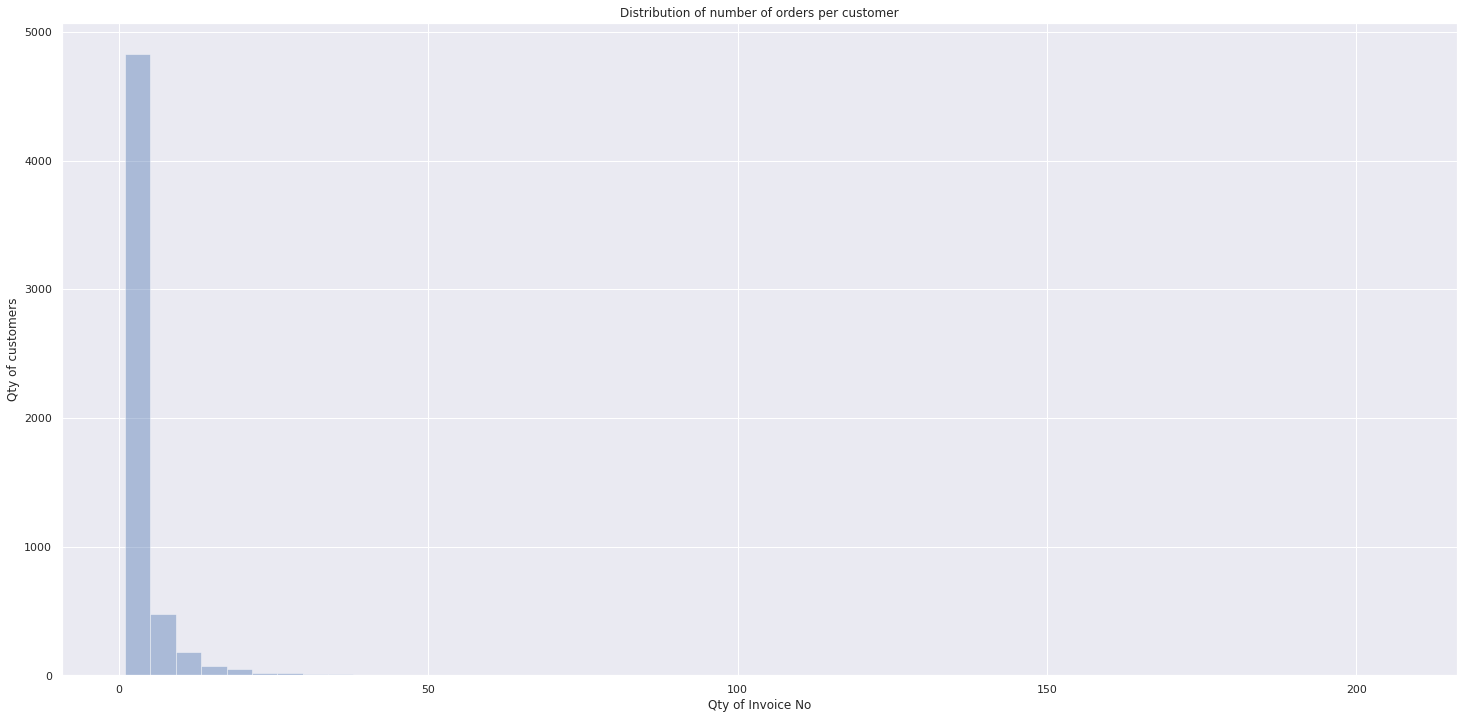

In [43]:
ax = sns.distplot(df_invoice_no['qty_invoice_no'], kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='Qty of Invoice No', 
       ylabel='Qty of customers')

## Cohort Analysis

- Cohort Analysis is a very useful and relatively simple technique that helps in getting valuable insights about the behavior of any business’ customers/users. For the analysis, we can focus on different metrics (dependent on the business model) — conversion, retention, generated revenue, etc.

- A cohort is a group of people sharing something in common, such as the sign-up date to an app, the month of the first purchase, geographical location, acquisition channel (organic users, coming from performance marketing, etc.) and so on. In Cohort Analysis, we track these groups of users over time, to identify some common patterns or behaviors.

- In this notebook I cover the case of **user retention** and **gross revenue**. By understanding user retention, we can infer the stickiness/loyalty of the customers and evaluate the health of the business. It is important to remember that the expected retention values vary greatly between businesses, 3 purchases a year for one retailer might be a lot, while for another might be far too little.

- Retaining customers is critical for any business, as it is far cheaper to keep the current customers (by using CRM tools, member discounts, etc.) than to acquire new ones.

- Furthermore, cohort analysis can also help to observe the impact of changes to the product on the user behavior, be it design changes or entirely new features. By seeing how the groups behave over time, we can more or less observe if our efforts had some effects on the user

In [44]:
df_aux = df1_purchases[['customer_id', 'invoice_no','gross_revenue', 'invoice_date']].groupby(['customer_id','invoice_no', 'invoice_date']).sum().reset_index()

In [45]:
df_aux.head()

,customer_id,invoice_no,invoice_date,gross_revenue
0,12347,537626,2016-12-05,711.79
1,12347,542237,2017-01-24,475.39
2,12347,549222,2017-04-05,636.25
3,12347,556201,2017-06-07,382.52
4,12347,562032,2017-07-31,584.91


In [46]:
df_aux['invoice_month'] = df_aux['invoice_date'].dt.to_period('M')

In [47]:
df_aux['cohort'] = df_aux.groupby('customer_id')['invoice_date'].transform('min').dt.to_period('M') 

In [48]:
df_aux.dtypes

customer_id               int64
invoice_no               object
invoice_date     datetime64[ns]
gross_revenue           float64
invoice_month         period[M]
cohort                period[M]
dtype: object

In [49]:
df_aux.sample(10)

,customer_id,invoice_no,invoice_date,gross_revenue,invoice_month,cohort
2731,13116,561068,2017-07-22,501.14,2017-07,2017-07
6521,14409,562769,2017-08-07,190.80,2017-08,2016-12
39,12362,559295,2017-07-05,273.76,2017-07,2017-02
273,12445,577125,2017-11-15,77.40,2017-11,2017-11
14190,16919,548971,2017-04-03,184.84,2017-04,2016-12
18155,18203,559018,2017-07-03,160.42,2017-07,2017-07
177,12417,580965,2017-12-04,324.73,2017-12,2016-12
8904,15079,552813,2017-05-09,314.47,2017-05,2016-12
18233,18226,562965,2017-08-09,666.80,2017-08,2017-01
3251,13305,577176,2017-11-16,316.45,2017-11,2016-11


In [50]:
df_aux[df_aux['customer_id'] == 16460]

,customer_id,invoice_no,invoice_date,gross_revenue,invoice_month,cohort
12812,16460,567200,2017-09-17,258.84,2017-09,2017-09
12813,16460,568657,2017-09-26,253.26,2017-09,2017-09
12814,16460,575885,2017-11-09,302.62,2017-11,2017-09


In [51]:
# creating cohort dataset
df_cohort = df_aux[['customer_id','invoice_month','gross_revenue', 'cohort']].groupby(['cohort', 'invoice_month']).agg(qty_customers = ('customer_id', 'nunique'), gross_revenue = ('gross_revenue', 'sum')).reset_index()

In [52]:
# period_number, which indicates the number of periods between the cohort month and the month of the purchase.
df_cohort['period_number'] = (df_cohort['invoice_month'] - df_cohort['cohort']).apply(attrgetter('n'))

In [53]:
df_cohort[df_cohort['cohort'] == '2016-11']

,cohort,invoice_month,qty_customers,gross_revenue,period_number
0,2016-11,2016-11,199,105406.71,0
1,2016-11,2016-12,71,85513.09,1
2,2016-11,2017-01,68,70762.53,2
3,2016-11,2017-02,62,51383.03,3
4,2016-11,2017-03,68,73834.40,4
5,2016-11,2017-04,69,46454.89,5
6,2016-11,2017-05,74,84965.09,6
7,2016-11,2017-06,71,69643.69,7
8,2016-11,2017-07,62,68411.52,8
9,2016-11,2017-08,69,87363.85,9


In [54]:
df_cohort[df_cohort['cohort'] == '2017-02']

,cohort,invoice_month,qty_customers,gross_revenue,period_number
39,2017-02,2017-02,464,222129.74,0
40,2017-02,2017-03,62,26779.15,1
41,2017-02,2017-04,63,33211.46,2
42,2017-02,2017-05,107,47591.28,3
43,2017-02,2017-06,95,35631.65,4
44,2017-02,2017-07,86,35956.19,5
45,2017-02,2017-08,85,44839.81,6
46,2017-02,2017-09,100,56700.93,7
47,2017-02,2017-10,95,52282.50,8
48,2017-02,2017-11,111,63652.97,9


### Cohort for Retention

In [55]:
# creating retention cohort table
cohort_pivot_retention = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'qty_customers')

cohort_pivot_retention.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.0f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,199,71,68,62,68,69,74,71,62,69,74,72,91,33
2016-12,842,267,220,268,237,278,243,245,247,263,279,363,150,nan
2017-01,580,94,126,107,152,132,121,119,136,150,172,38,nan,nan
2017-02,464,62,63,107,95,86,85,100,95,111,17,nan,nan,nan
2017-03,553,61,112,83,101,75,107,107,112,32,nan,nan,nan,nan
2017-04,375,60,57,59,57,63,63,77,15,nan,nan,nan,nan,nan
2017-05,433,59,49,49,61,71,84,15,nan,nan,nan,nan,nan,nan
2017-06,355,43,38,58,57,74,15,nan,nan,nan,nan,nan,nan,nan
2017-07,328,34,38,45,53,18,nan,nan,nan,nan,nan,nan,nan,nan


In [56]:
# getting percentage values
cohort_size_retention = cohort_pivot_retention.iloc[:,0]
retention_matrix = cohort_pivot_retention.divide(cohort_size_retention, axis = 0)

retention_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.4f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,1.0000,0.3568,0.3417,0.3116,0.3417,0.3467,0.3719,0.3568,0.3116,0.3467,0.3719,0.3618,0.4573,0.1658
2016-12,1.0000,0.3171,0.2613,0.3183,0.2815,0.3302,0.2886,0.2910,0.2933,0.3124,0.3314,0.4311,0.1781,nan
2017-01,1.0000,0.1621,0.2172,0.1845,0.2621,0.2276,0.2086,0.2052,0.2345,0.2586,0.2966,0.0655,nan,nan
2017-02,1.0000,0.1336,0.1358,0.2306,0.2047,0.1853,0.1832,0.2155,0.2047,0.2392,0.0366,nan,nan,nan
2017-03,1.0000,0.1103,0.2025,0.1501,0.1826,0.1356,0.1935,0.1935,0.2025,0.0579,nan,nan,nan,nan
2017-04,1.0000,0.1600,0.1520,0.1573,0.1520,0.1680,0.1680,0.2053,0.0400,nan,nan,nan,nan,nan
2017-05,1.0000,0.1363,0.1132,0.1132,0.1409,0.1640,0.1940,0.0346,nan,nan,nan,nan,nan,nan
2017-06,1.0000,0.1211,0.1070,0.1634,0.1606,0.2085,0.0423,nan,nan,nan,nan,nan,nan,nan
2017-07,1.0000,0.1037,0.1159,0.1372,0.1616,0.0549,nan,nan,nan,nan,nan,nan,nan,nan


### Cohort for Revenue

In [57]:
# creating Gross Revenue cohort table
cohort_pivot_revenue = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'gross_revenue')

cohort_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,105406.71,85513.09,70762.53,51383.03,73834.40,46454.89,84965.09,69643.69,68411.52,87363.85,95958.92,124078.42,152474.32,41620.56
2016-12,587703.56,223913.89,176874.98,217293.77,149132.16,258303.12,229788.36,240500.89,274166.00,337653.49,352491.92,369677.00,99548.67,nan
2017-01,349087.89,53053.78,69443.09,69355.97,96276.32,79841.19,78095.28,82382.68,73246.43,119511.44,130243.21,20770.00,nan,nan
2017-02,222129.74,26779.15,33211.46,47591.28,35631.65,35956.19,44839.81,56700.93,52282.50,63652.97,5368.57,nan,nan,nan
2017-03,286419.35,25640.32,61235.79,38343.90,51106.60,43959.12,58104.63,72418.55,64918.83,8359.97,nan,nan,nan,nan
2017-04,174389.12,25017.57,21946.05,20350.68,21397.73,26524.54,28118.51,31745.60,4036.37,nan,nan,nan,nan,nan
2017-05,212172.94,18922.26,21007.35,18238.01,28857.20,34910.68,39398.27,5105.48,nan,nan,nan,nan,nan,nan
2017-06,166194.24,15286.00,12523.26,28636.02,25866.51,38540.42,4466.28,nan,nan,nan,nan,nan,nan,nan
2017-07,190987.22,11336.00,16463.78,19317.90,20534.76,4769.61,nan,nan,nan,nan,nan,nan,nan,nan


In [58]:
# getting percentage values
cohort_size_revenue = cohort_pivot_revenue.iloc[:,0]
revenue_matrix = cohort_pivot_revenue.divide(cohort_size_revenue, axis = 0)

revenue_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.5f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,1.00000,0.81127,0.67133,0.48747,0.70047,0.44072,0.80607,0.66071,0.64902,0.82883,0.91037,1.17714,1.44653,0.39486
2016-12,1.00000,0.38100,0.30096,0.36973,0.25375,0.43951,0.39099,0.40922,0.46650,0.57453,0.59978,0.62902,0.16939,nan
2017-01,1.00000,0.15198,0.19893,0.19868,0.27579,0.22871,0.22371,0.23599,0.20982,0.34235,0.37310,0.05950,nan,nan
2017-02,1.00000,0.12056,0.14951,0.21425,0.16041,0.16187,0.20186,0.25526,0.23537,0.28656,0.02417,nan,nan,nan
2017-03,1.00000,0.08952,0.21380,0.13387,0.17843,0.15348,0.20287,0.25284,0.22666,0.02919,nan,nan,nan,nan
2017-04,1.00000,0.14346,0.12585,0.11670,0.12270,0.15210,0.16124,0.18204,0.02315,nan,nan,nan,nan,nan
2017-05,1.00000,0.08918,0.09901,0.08596,0.13601,0.16454,0.18569,0.02406,nan,nan,nan,nan,nan,nan
2017-06,1.00000,0.09198,0.07535,0.17230,0.15564,0.23190,0.02687,nan,nan,nan,nan,nan,nan,nan
2017-07,1.00000,0.05935,0.08620,0.10115,0.10752,0.02497,nan,nan,nan,nan,nan,nan,nan,nan


## Cohort Analysis by Clusters

* Cluster 6: Champions
* Cluster 4: Almost Champions
* Cluster 1: Must buy more frequently and more products
* Cluster 7: Must buy more expensive products
* Cluster 2: Must buy more items and different products
* Cluster 8: Churn 1
* Cluster 0: Churn 2
* Cluster 5: Churn 3
* Cluster 3: Churn 4

In [61]:
conn = sqlite3.connect('champions_db.sqlite')

In [62]:
# consulting database
# get query
query_collect = """
    SELECT * from champions
"""

df = pd.read_sql_query(query_collect, conn)
df.head()

,customer_id,gross_revenue,recency_days,qty_invoice_no,qty_items,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372,34,1733,297,17.000000,40,4
1,13047,3232.59,56,9,1390,171,0.028302,35,4
2,12583,6705.38,2,15,5028,232,0.040323,50,6
3,13748,948.25,95,5,439,28,0.017921,0,2
4,15100,876.00,333,3,80,3,0.073171,22,0


In [64]:
df2 = df[['customer_id', 'cluster']].copy()

In [65]:
teste = pd.merge(df_aux, df2, on = 'customer_id', how = 'left')

In [68]:
teste.isna().sum()

customer_id      0
invoice_no       0
invoice_date     0
gross_revenue    0
invoice_month    0
cohort           0
cluster          0
dtype: int64

In [66]:
teste.head()

,customer_id,invoice_no,invoice_date,gross_revenue,invoice_month,cohort,cluster
0,12347,537626,2016-12-05,711.79,2016-12,2016-12,6
1,12347,542237,2017-01-24,475.39,2017-01,2016-12,6
2,12347,549222,2017-04-05,636.25,2017-04,2016-12,6
3,12347,556201,2017-06-07,382.52,2017-06,2016-12,6
4,12347,562032,2017-07-31,584.91,2017-07,2016-12,6


In [75]:
teste.shape

(19765, 7)

In [76]:
df_only_champions.shape

(7308, 7)

In [74]:
# filtering the dataset by clusters
df_only_champions = teste[teste['cluster']==6].copy()
df_only_champions.sample(5)

,customer_id,invoice_no,invoice_date,gross_revenue,invoice_month,cohort,cluster
18149,18198,575140,2017-11-06,303.08,2017-11,2017-01,6
17520,17966,547558,2017-03-21,147.00,2017-03,2017-03,6
12065,16182,544351,2017-02-16,825.00,2017-02,2017-02,6
12155,16210,536477,2016-11-29,2474.74,2016-11,2016-11,6
16414,17677,537228,2016-12-04,25.20,2016-12,2016-12,6


In [77]:
# creating cohort dataset
df_cohort_champions = df_only_champions[['customer_id','invoice_month','gross_revenue', 'cohort', 'cluster']].groupby(['cohort', 'invoice_month', 'cluster']).agg(qty_customers = ('customer_id', 'nunique'), gross_revenue = ('gross_revenue', 'sum')).reset_index()

In [78]:
df_cohort_champions.head()

,cohort,invoice_month,cluster,qty_customers,gross_revenue
0,2016-11,2016-11,6,56,54176.19
1,2016-11,2016-12,6,38,76740.35
2,2016-11,2017-01,6,40,61439.69
3,2016-11,2017-02,6,41,45167.58
4,2016-11,2017-03,6,40,66101.11


In [79]:
# period_number, which indicates the number of periods between the cohort month and the month of the purchase.
df_cohort_champions['period_number'] = (df_cohort_champions['invoice_month'] - df_cohort_champions['cohort']).apply(attrgetter('n'))

In [80]:
df_cohort_champions[df_cohort_champions['cohort'] == '2016-11']

,cohort,invoice_month,cluster,qty_customers,gross_revenue,period_number
0,2016-11,2016-11,6,56,54176.19,0
1,2016-11,2016-12,6,38,76740.35,1
2,2016-11,2017-01,6,40,61439.69,2
3,2016-11,2017-02,6,41,45167.58,3
4,2016-11,2017-03,6,40,66101.11,4
5,2016-11,2017-04,6,37,37803.44,5
6,2016-11,2017-05,6,45,75567.04,6
7,2016-11,2017-06,6,44,61743.44,7
8,2016-11,2017-07,6,42,64046.34,8
9,2016-11,2017-08,6,42,80004.26,9


### Champios Retention Cohort

In [85]:
# creating retention cohort table
cohort_champions_pivot_retention = df_cohort_champions.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'qty_customers')

cohort_champions_pivot_retention.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.0f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,56,38,40,41,40,37,45,44,42,42,43,43,50,25
2016-12,202,137,116,144,130,144,129,140,135,140,144,161,85,nan
2017-01,68,26,45,29,44,46,43,42,39,43,54,19,nan,nan
2017-02,49,19,23,30,29,27,26,29,24,32,7,nan,nan,nan
2017-03,45,17,26,25,27,27,28,30,31,8,nan,nan,nan,nan
2017-04,8,4,3,5,5,4,6,4,1,nan,nan,nan,nan,nan
2017-05,13,7,8,6,5,7,7,2,nan,nan,nan,nan,nan,nan
2017-06,15,8,6,11,10,8,4,nan,nan,nan,nan,nan,nan,nan
2017-07,6,2,4,3,2,1,nan,nan,nan,nan,nan,nan,nan,nan


In [86]:
# getting percentage values
cohort_size_retention = cohort_champions_pivot_retention.iloc[:,0]
retention_matrix = cohort_champions_pivot_retention.divide(cohort_size_retention, axis = 0)

retention_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.4f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,1.0000,0.6786,0.7143,0.7321,0.7143,0.6607,0.8036,0.7857,0.7500,0.7500,0.7679,0.7679,0.8929,0.4464
2016-12,1.0000,0.6782,0.5743,0.7129,0.6436,0.7129,0.6386,0.6931,0.6683,0.6931,0.7129,0.7970,0.4208,nan
2017-01,1.0000,0.3824,0.6618,0.4265,0.6471,0.6765,0.6324,0.6176,0.5735,0.6324,0.7941,0.2794,nan,nan
2017-02,1.0000,0.3878,0.4694,0.6122,0.5918,0.5510,0.5306,0.5918,0.4898,0.6531,0.1429,nan,nan,nan
2017-03,1.0000,0.3778,0.5778,0.5556,0.6000,0.6000,0.6222,0.6667,0.6889,0.1778,nan,nan,nan,nan
2017-04,1.0000,0.5000,0.3750,0.6250,0.6250,0.5000,0.7500,0.5000,0.1250,nan,nan,nan,nan,nan
2017-05,1.0000,0.5385,0.6154,0.4615,0.3846,0.5385,0.5385,0.1538,nan,nan,nan,nan,nan,nan
2017-06,1.0000,0.5333,0.4000,0.7333,0.6667,0.5333,0.2667,nan,nan,nan,nan,nan,nan,nan
2017-07,1.0000,0.3333,0.6667,0.5000,0.3333,0.1667,nan,nan,nan,nan,nan,nan,nan,nan


### Cohort for Revenue

In [87]:
# creating Gross Revenue cohort table
cohort_champions_pivot_revenue = df_cohort_champions.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'gross_revenue')

cohort_champions_pivot_revenue.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.2f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,54176.19,76740.35,61439.69,45167.58,66101.11,37803.44,75567.04,61743.44,64046.34,80004.26,84492.34,111387.53,136254.14,39167.69
2016-12,282139.54,178951.59,142531.90,177041.05,118504.47,214595.18,195706.48,206774.73,235885.07,297832.57,302145.97,283751.36,81048.40,nan
2017-01,91836.00,32889.33,44694.46,46692.89,60629.47,53901.05,51762.94,57587.74,39735.24,71268.01,83643.99,16104.79,nan,nan
2017-02,46544.70,14439.43,19359.80,21996.50,17585.20,15453.04,24928.23,25383.37,25351.93,37654.85,3228.58,nan,nan,nan
2017-03,69002.97,10464.71,27686.18,19484.20,24386.74,27920.77,27394.00,39499.59,30821.19,2814.83,nan,nan,nan,nan
2017-04,11514.66,4206.00,2302.88,4525.30,3206.60,5229.02,4836.57,3500.34,367.88,nan,nan,nan,nan,nan
2017-05,20050.35,3650.43,5651.53,4357.15,5100.18,9045.21,7135.08,755.17,nan,nan,nan,nan,nan,nan
2017-06,25513.20,7938.20,3573.33,11268.51,6416.57,10235.49,1208.50,nan,nan,nan,nan,nan,nan,nan
2017-07,11918.18,1777.37,3862.31,2196.85,1112.63,382.96,nan,nan,nan,nan,nan,nan,nan,nan


In [91]:
# getting percentage values
cohort_size_revenue = cohort_champions_pivot_revenue.iloc[:,0]
revenue_matrix = cohort_champions_pivot_revenue.divide(cohort_size_revenue, axis = 0)

revenue_matrix.style.highlight_max(color = 'lightgreen', axis = 0).format('{:.5f}')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2016-11,1.00000,1.41650,1.13407,0.83372,1.22011,0.69779,1.39484,1.13968,1.18219,1.47674,1.55958,2.05602,2.51502,0.72297
2016-12,1.00000,0.63427,0.50518,0.62749,0.42002,0.76060,0.69365,0.73288,0.83606,1.05562,1.07091,1.00571,0.28726,nan
2017-01,1.00000,0.35813,0.48668,0.50844,0.66019,0.58693,0.56365,0.62707,0.43268,0.77604,0.91080,0.17536,nan,nan
2017-02,1.00000,0.31023,0.41594,0.47259,0.37781,0.33200,0.53558,0.54535,0.54468,0.80900,0.06937,nan,nan,nan
2017-03,1.00000,0.15166,0.40123,0.28237,0.35342,0.40463,0.39700,0.57243,0.44666,0.04079,nan,nan,nan,nan
2017-04,1.00000,0.36527,0.20000,0.39300,0.27848,0.45412,0.42004,0.30399,0.03195,nan,nan,nan,nan,nan
2017-05,1.00000,0.18206,0.28187,0.21731,0.25437,0.45112,0.35586,0.03766,nan,nan,nan,nan,nan,nan
2017-06,1.00000,0.31114,0.14006,0.44167,0.25150,0.40118,0.04737,nan,nan,nan,nan,nan,nan,nan
2017-07,1.00000,0.14913,0.32407,0.18433,0.09336,0.03213,nan,nan,nan,nan,nan,nan,nan,nan


# Cohort Results

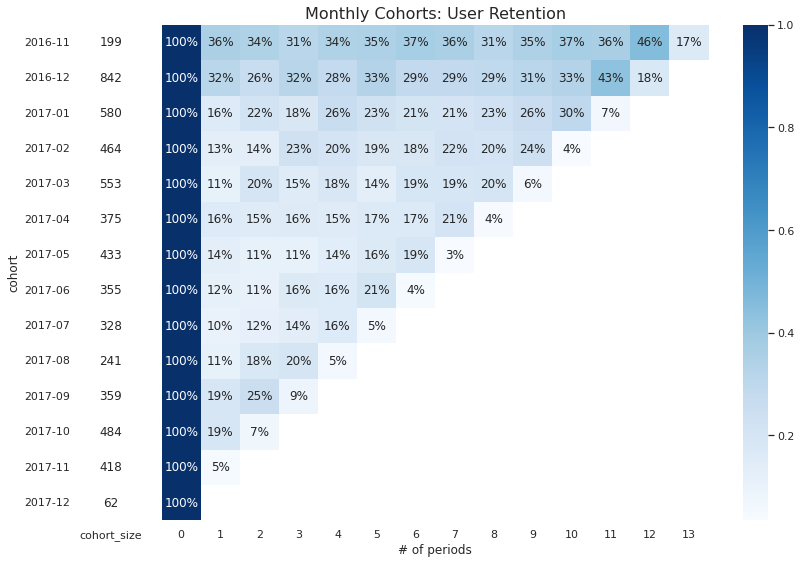

In [59]:
# Cohort for Retention
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='Blues', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_retention).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

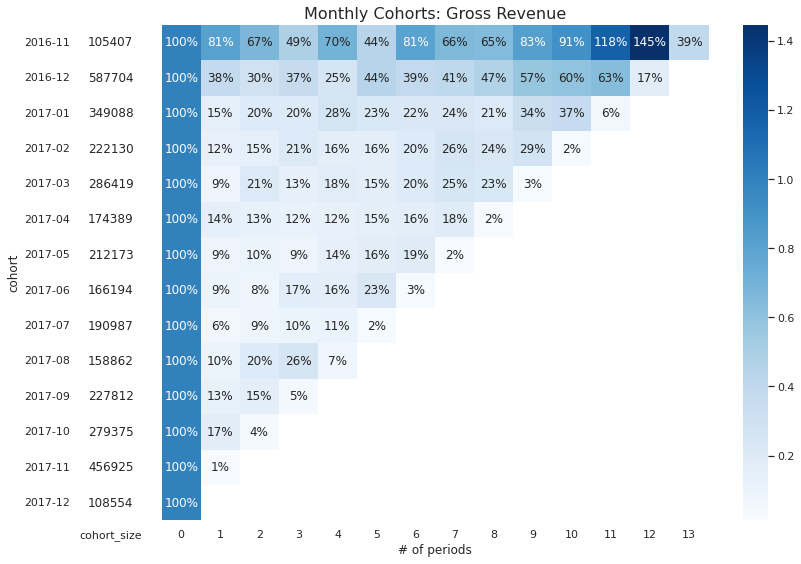

In [60]:
# Cohort for Gross Revenue
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(revenue_matrix, 
                mask=revenue_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='Blues', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Gross Revenue', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_revenue).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

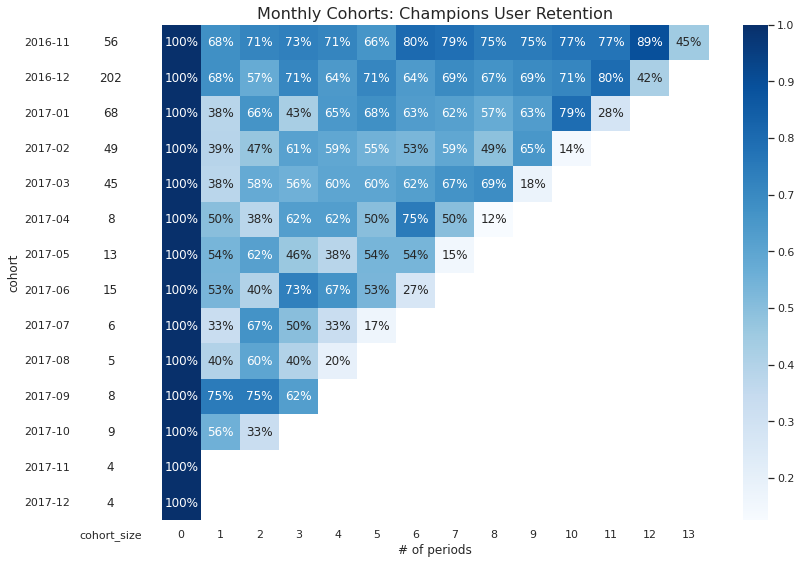

In [92]:
# Cohort for Retention
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='Blues', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Champions User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_retention).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

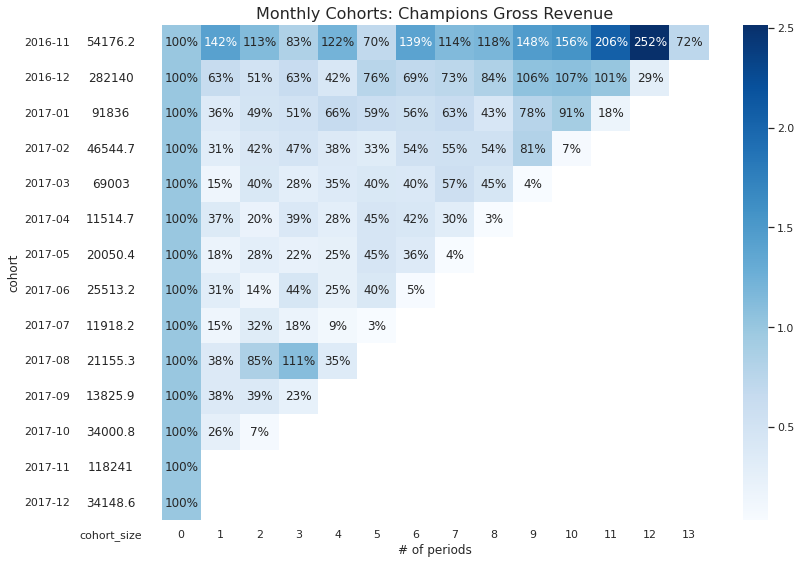

In [93]:
# Cohort for Gross Revenue
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(revenue_matrix, 
                mask=revenue_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='Blues', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Champions Gross Revenue', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_revenue).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# Conclusion

- In the image, we can see that there is a sharp drop-off in the second month (indexed as 1) already, on average around 80% of customers do not make any purchase in the second month. 

- The first and second cohort (2016–11/12) seems to be an exception and performs surprisingly well as compared to the other ones. A year after the first purchase, there is a 46 and 43% retention, respectively. This might be a cohort of dedicated customers, who first joined the platform based on some already-existing connections with the retailer. However, from data alone, that is very hard to accurately explain.

- Also we can see many customers coming back to buy in November, probably due to Black-Friday.

- Throughout the matrix, we can see fluctuations in retention and revenue over time. This might be caused by the characteristics of the business, where clients do periodic purchases, followed by periods of inactivity.

# Next Steps

- Merge the generated cluster with the cohort dataset to make the analyse by Clsuter
- Create a streamlit app where the CEO can filter the cohort analysis by Cluster
- Deploy to Heroku